#**Disaster Tweets Classification using NLP**

#Introduction

This project aims to build a Machine Learning model that predicts which Tweets are about real disasters and which ones aren’t.

The steps taken:
1.   Exploratory Data Analysis of tweets
2.   Data Cleaning
3.   GloVe for Vectorization







## Import required libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
stopW = set(stopwords.words('english'))

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from collections import defaultdict
from collections import  Counter

import re
import string

from tqdm import tqdm

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Colab library to upload files to notebook
from google.colab import files

In [ ]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle
#Install Kaggle
!pip install -q kaggle
!pip install -q kaggle-cli

kaggle.json
     |████████████████████████████████| 81kB 4.8MB/s 
     |████████████████████████████████| 5.3MB 10.9MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 133kB 44.4MB/s 
     |████████████████████████████████| 112kB 44.5MB/s 


In [ ]:
#Download the dataset
!kaggle competitions download -c nlp-getting-started

  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 60.9MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 57.0MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 20.6MB/s]


In [ ]:
!ls

kaggle.json  sample_data  sample_submission.csv  test.csv  train.csv


In [ ]:
# Loading the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
print('There are {} rows and {} columns in train'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


In [ ]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


#Exploratory Data Analysis (EDA)
------------------------

## Target Class Distribution
-----------------

In [ ]:
# Extracting the number of targets of each class
real_tweets = train[train['target'] == 1].shape[0]
notReal_tweets = train[train['target'] == 0].shape[0]

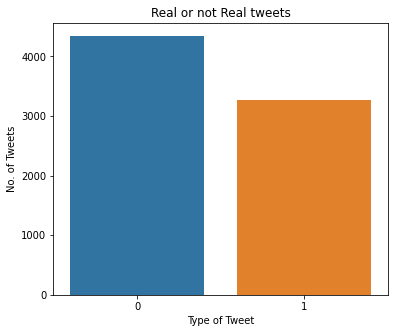

In [ ]:
#set figure size
fig, ax = plt.subplots(figsize = (6, 5))

#create graphs
graph1 = sns.countplot(x = 'target', data = train)

#add title and plot
plt.title('Real or not Real tweets')
plt.xlabel('Type of Tweet')
plt.ylabel('No. of Tweets')

plt.show(graph1)

In [ ]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

From the above graph, we can conclude that we have more tweets in class 0 which represents '**not a disaster tweet**' than class 1 which represents '**disaster tweet**'.

## Number of Characters Distribution in a Tweet
-------------

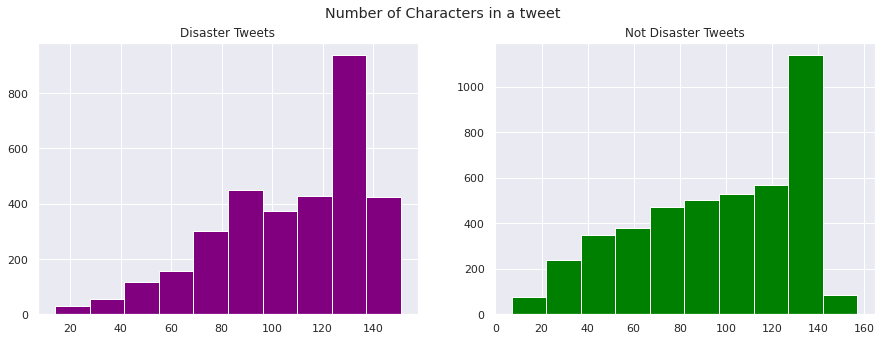

In [ ]:
sns.set()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
disTweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(disTweet_len,color='purple')
ax1.set_title('Disaster Tweets')

nondisTweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(nondisTweet_len,color= 'green')
ax2.set_title('Not Disaster Tweets')
fig.suptitle('Number of Characters in a tweet')
plt.show()

## Number of Words in a Tweet
-------------------

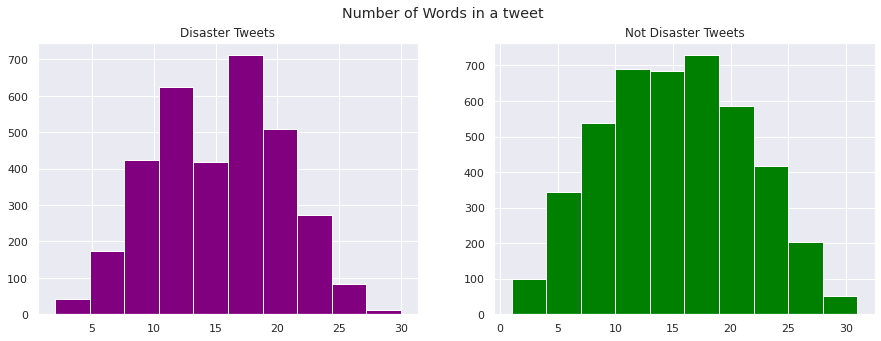

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
disWords = train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(disWords,color='purple')
ax1.set_title('Disaster Tweets')
nondisWords=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(nondisWords,color='green')
ax2.set_title('Not Disaster Tweets')
fig.suptitle('Number of Words in a tweet')
plt.show()

##Average Word Length in a Tweet
------------------

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average Word Length in each tweet')

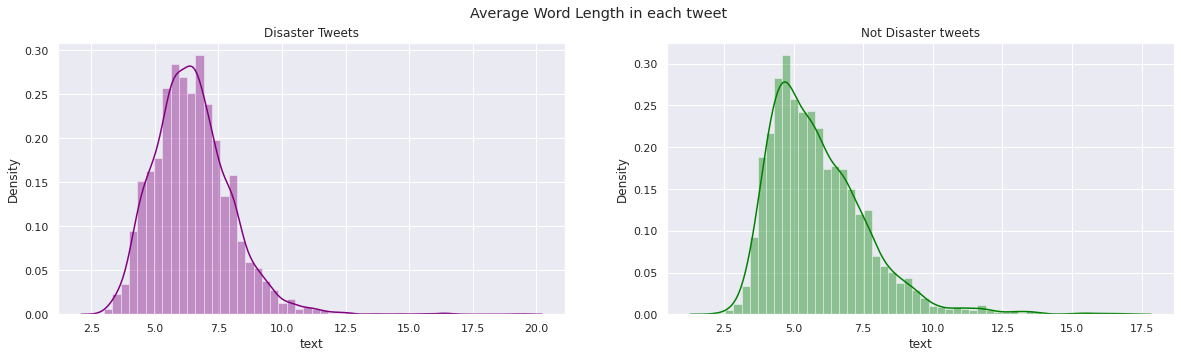

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
diswordlen = train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(diswordlen.map(lambda x: np.mean(x)),ax=ax1,color='purple')
ax1.set_title('Disaster Tweets')

nondiswordlen = train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(nondiswordlen.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Disaster tweets')
fig.suptitle('Average Word Length in each tweet')

## Common Stopwords in Tweets
---------------------

Corpus is a collection of texts.

In [ ]:
def create_corpus(target):
    corpus = []
    
    for x in train[train['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

### Analyze tweets which doesn't indicate disaster (target = 0)

In [ ]:
corpus = create_corpus(0)

nondis_dict = defaultdict(int)
for word in corpus:
    if word in stopW:
        nondis_dict[word] += 1
        
nondis_topWords = sorted(nondis_dict.items(), key = lambda x:x[1],reverse = True)[:10] 

In [ ]:
print(nondis_topWords)

[('the', 1524), ('a', 1115), ('to', 1099), ('and', 840), ('of', 834), ('in', 720), ('you', 529), ('is', 512), ('for', 452), ('my', 442)]


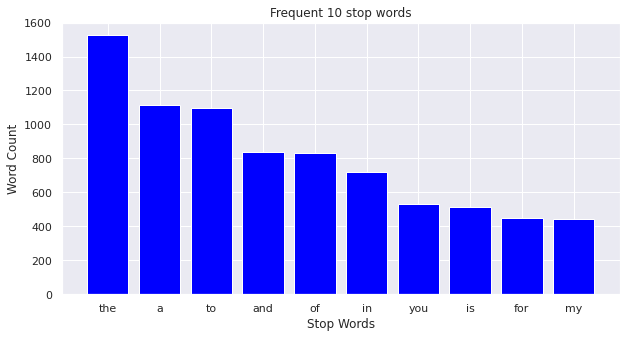

In [ ]:
#set figure size
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
x,y=zip(*nondis_topWords)
plt.bar(x,y, color = 'blue')

#add title and plot
plt.title('Frequent 10 stop words')
plt.xlabel('Stop Words')
plt.ylabel('Word Count')

plt.show()

### Analyze tweets which indicate disaster (target = 1)

In [ ]:
corpus = create_corpus(1)

dis_dict = defaultdict(int)
for word in corpus:
    if word in stopW:
        dis_dict[word] += 1

dis_topWords = sorted(dis_dict.items(), key = lambda x:x[1],reverse = True)[:10] 

In [ ]:
print(dis_topWords)

[('the', 1051), ('in', 1037), ('of', 888), ('a', 730), ('to', 706), ('and', 462), ('on', 386), ('for', 368), ('is', 302), ('at', 273)]


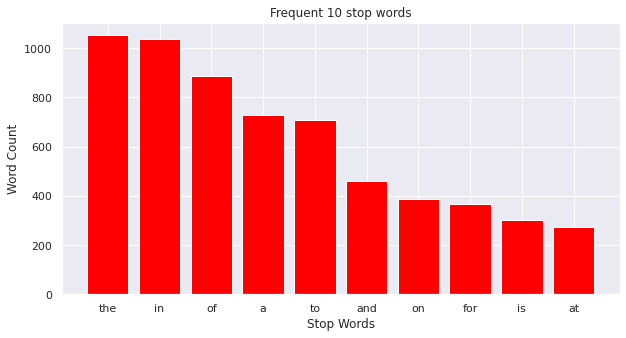

In [ ]:
#set figure size
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
x,y=zip(*dis_topWords)
plt.bar(x,y, color = 'red')

#add title and plot
plt.title('Frequent 10 stop words')
plt.xlabel('Stop Words')
plt.ylabel('Word Count')

plt.show()

The word 'the' appears the most number of times in both the target classes

## Analyzing Punctuations
----------------------

### Analyze tweets which doesn't indicate disaster (target = 0)

In [ ]:
corpus=create_corpus(0)

dict_punct0 = defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dict_punct0[i]+=1

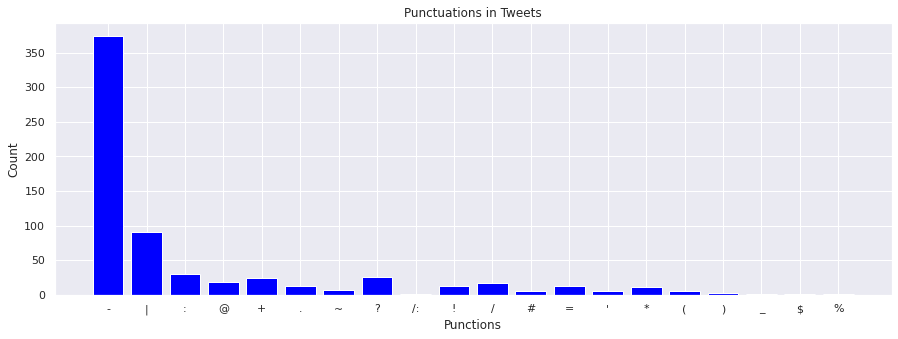

In [ ]:
#set figure size
fig, ax = plt.subplots(figsize = (15, 5))

x,y=zip(*dict_punct0.items())
plt.bar(x,y, color ='blue')

#add title and plot
plt.title('Punctuations in Tweets')
plt.xlabel('Punctions')
plt.ylabel('Count')

plt.show()


### Analyze tweets which indicate disaster (target = 1)

In [ ]:
corpus=create_corpus(1)

dict_punct1 = defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dict_punct1[i]+=1

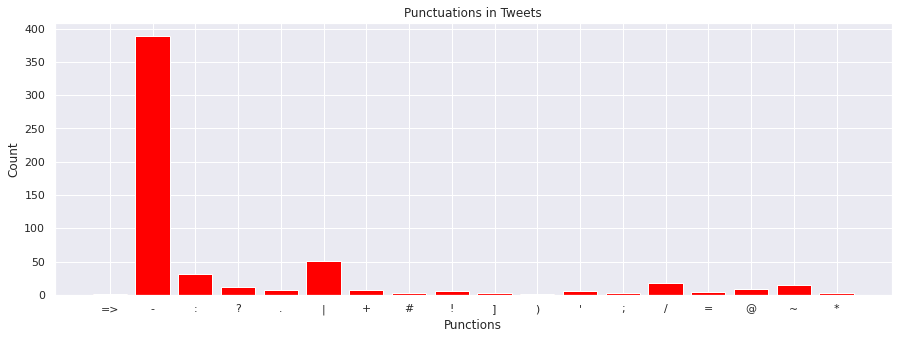

In [ ]:
#set figure size
fig, ax = plt.subplots(figsize = (15, 5))

x,y=zip(*dict_punct1.items())
plt.bar(x,y, color = 'red')

#add title and plot
plt.title('Punctuations in Tweets')
plt.xlabel('Punctions')
plt.ylabel('Count')
plt.show()

Punctuation mark '-' appears the most in both the target classes.

## Most Common Words
-----

In [ ]:
counter=Counter(corpus)
most=counter.most_common()
x_ax = []
y_ax = []
for word, count in most[:50]:
    if (word not in stopW):
        x_ax.append(word)
        y_ax.append(count)

Text(0, 0.5, 'Count')

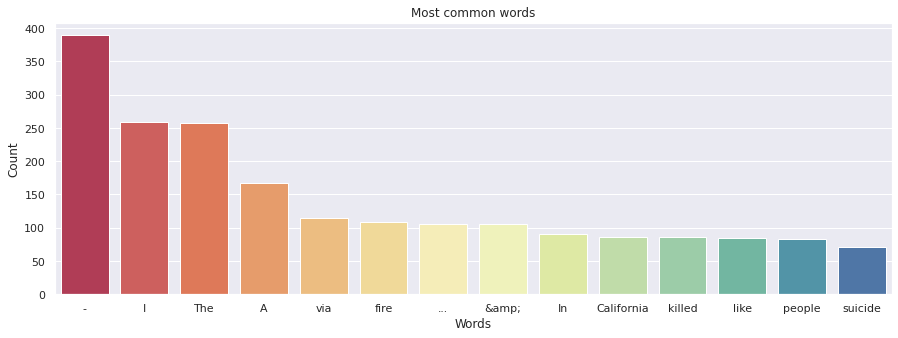

In [ ]:
plt.subplots(figsize = (15, 5))
sns.barplot(x = x_ax, y = y_ax, palette= 'Spectral')
#add title and plot
plt.title('Most common words')
plt.xlabel('Words')
plt.ylabel('Count')

## Location of Tweets

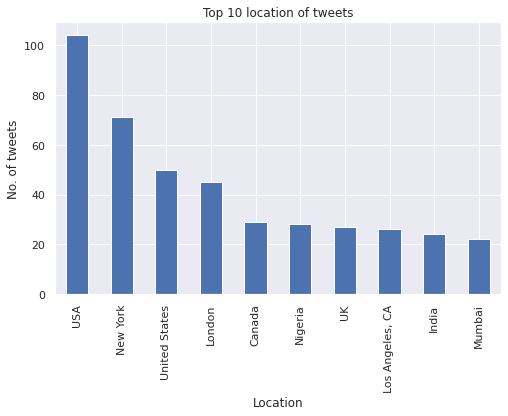

In [ ]:
axs = train['location'].value_counts()[:10].plot(kind = 'bar', figsize = (8,5), title = 'Top 10 location of tweets')
plt.ylabel('No. of tweets')
plt.xlabel('Location')
plt.show()

## N-Gram analysis
------

unigram

In [ ]:
def get_topTweets_Unigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

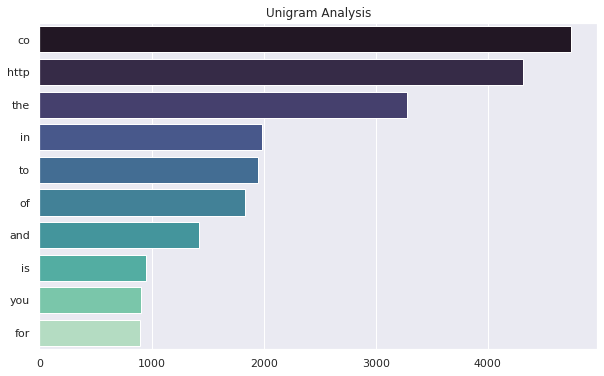

In [ ]:
plt.figure(figsize=(10,6))
topTweets_Unigram = get_topTweets_Unigram(train['text'])[:10]
x,y=map(list,zip(*topTweets_Unigram))
sns.barplot(x=y,y=x, palette= 'mako')
plt.title('Unigram Analysis')
plt.show()

bigram

In [ ]:
def get_topTweets_Bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

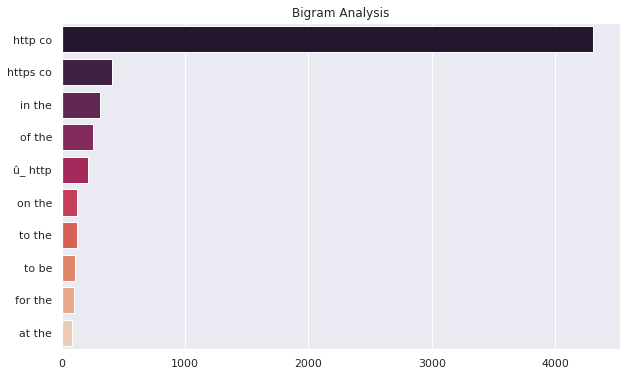

In [ ]:
plt.figure(figsize=(10,6))
topTweets_Bigram = get_topTweets_Bigram(train['text'])[:10]
x,y=map(list,zip(*topTweets_Bigram))
sns.barplot(x=y,y=x, palette= 'rocket')
plt.title('Bigram Analysis')
plt.show()

trigram

In [ ]:
def get_topTweets_Trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

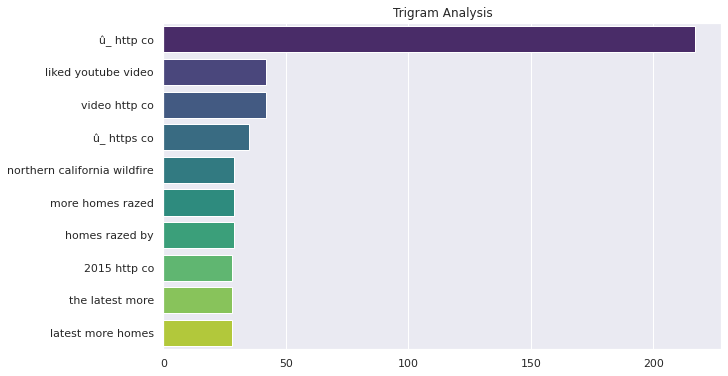

In [ ]:
plt.figure(figsize=(10,6))
topTweets_Trigram = get_topTweets_Trigram(train['text'])[:10]
x,y=map(list,zip(*topTweets_Trigram))
sns.barplot(x=y,y=x, palette= 'viridis')
plt.title('Trigram Analysis')
plt.show()

four-gram

In [ ]:
def get_topTweets_fourgram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

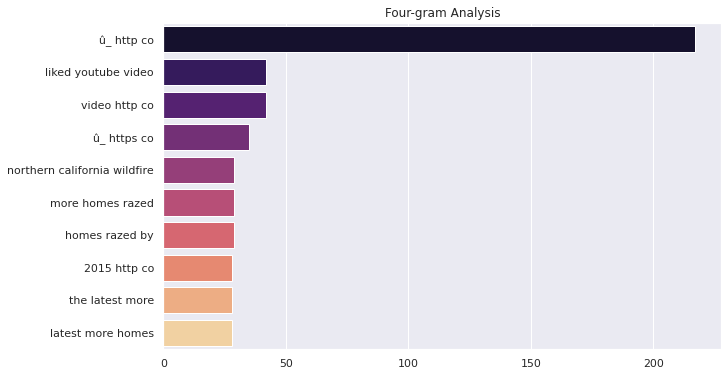

In [ ]:
plt.figure(figsize=(10,6))
topTweets_fourgram = get_topTweets_fourgram(train['text'])[:10]
x,y=map(list,zip(*topTweets_fourgram))
sns.barplot(x=y,y=x, palette = 'magma')
plt.title('Four-gram Analysis')
plt.show()

# Data Cleaning

In [ ]:
# Concatenating train and test datasets for data cleaning process
allTweets = pd.concat([train,test])

In [ ]:
allTweets.shape

(10876, 5)

## Remove URLs

In [ ]:
allTweets['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260    Green Line derailment in Chicago http://t.co/U...
3261    MEG issues Hazardous Weather Outlook (HWO) htt...
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 10876, dtype: object

There is a URL in the row 3260 which has to be removed.

In [ ]:
def rem_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [ ]:
allTweets['text'] = allTweets['text'].apply(lambda x : rem_URL(x))
allTweets['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260                    Green Line derailment in Chicago 
3261          MEG issues Hazardous Weather Outlook (HWO) 
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 10876, dtype: object

Row 3260 does not contain the URL anymore.

## Remove HTML tags

In [ ]:
def rem_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

In [ ]:
allTweets['text'] = allTweets['text'].apply(lambda x : rem_html(x))
allTweets['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260                    Green Line derailment in Chicago 
3261          MEG issues Hazardous Weather Outlook (HWO) 
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 10876, dtype: object

## Remove Emojis

In [ ]:
def rem_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
allTweets['text'] = allTweets['text'].apply(lambda x : rem_emoji(x))
allTweets['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260                    Green Line derailment in Chicago 
3261          MEG issues Hazardous Weather Outlook (HWO) 
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 10876, dtype: object

## Remove Punctuations

In [ ]:
def rem_punctns(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [ ]:
allTweets['text'] = allTweets['text'].apply(lambda x : rem_punctns(x))
allTweets['text']

0       Our Deeds are the Reason of this earthquake Ma...
1                   Forest fire near La Ronge Sask Canada
2       All residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       Just got sent this photo from Ruby Alaska as s...
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane My citya...
3260                    Green Line derailment in Chicago 
3261            MEG issues Hazardous Weather Outlook HWO 
3262    CityofCalgary has activated its Municipal Emer...
Name: text, Length: 10876, dtype: object

# WordCloud

Disaster Tweets

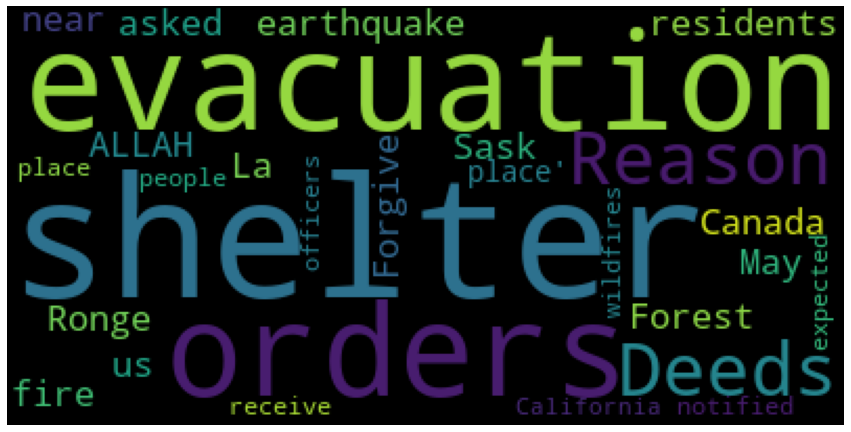

In [ ]:
corpus = create_corpus(1)

word_cloud = WordCloud(
    background_color='black',
    max_font_size = 80
    ).generate(" ".join(corpus[:50]))

plt.figure(figsize=(15,8))
plt.imshow(word_cloud)
plt.grid(b=None)
plt.axis('off')
plt.savefig('WordCloud_D.pdf')

Non_Disaster Tweets

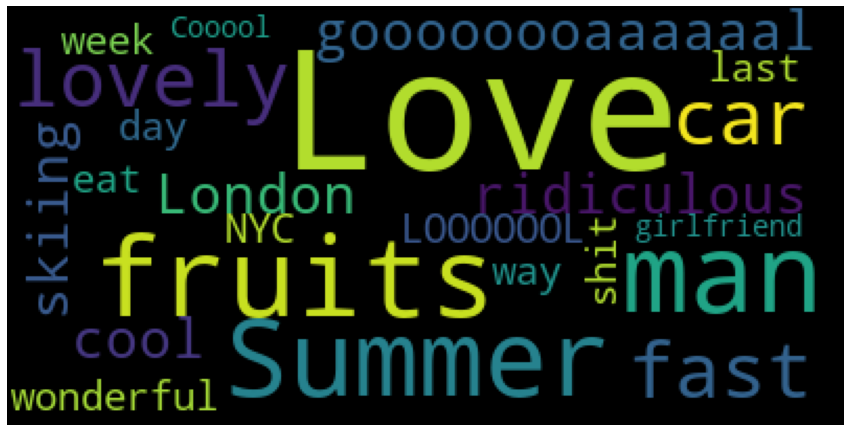

In [ ]:
corpus = create_corpus(0)

word_cloud = WordCloud(
    background_color='black',
    max_font_size = 80
    ).generate(" ".join(corpus[:50]))

plt.figure(figsize=(15,8))
plt.imshow(word_cloud)
plt.grid(b=None)
plt.axis('off')
plt.savefig('WordCloud_ND.pdf')

Visualizing the embeddings

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Not Real')
            blue_patch = mpatches.Patch(color='blue', label='Real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 15})

# GloVe for Vectorization

Here we will use GloVe pretrained corpus model to represent our words. It is available in 3 varieties : 50D, 100D and 200 Dimentional. We will try 100D here.

In [ ]:
!wget "http://nlp.stanford.edu/data/glove.6B.zip"

--2020-12-12 05:16:23--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-12-12 05:16:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-12-12 05:16:24--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip "glove.6B.zip"

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus

In [ ]:
import nltk
nltk.download('punkt')

corpus=create_corpus(allTweets)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


100%|██████████| 10876/10876 [00:01<00:00, 5688.80it/s]


In [ ]:
embedding_dict={}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [ ]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 22807


In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec 

100%|██████████| 22807/22807 [00:00<00:00, 486299.52it/s]


In [ ]:
tweet_pad[0][0:]

array([ 100, 5778,   20,    1,  814,    5,   18,  237,  136, 1902, 3703,
         68,   39,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

## Baseline Model with GloVe results

In [ ]:
model = Sequential()

embedding = Embedding(num_words, 100, embeddings_initializer = Constant(embedding_matrix), input_length = MAX_LEN, trainable = False)

model.add(embedding)
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
optimzer = Adam(learning_rate=3e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           2280800   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 2,361,301
Trainable params: 80,501
Non-trainable params: 2,280,800
_________________________________________________________________


In [ ]:
trainTWT = tweet_pad[:train.shape[0]]
trainTWT

array([[ 100, 5778,   20, ...,    0,    0,    0],
       [ 155,   41,  201, ...,    0,    0,    0],
       [  39, 1558, 1471, ...,    0,    0,    0],
       ...,
       [4188, 5708, 8166, ...,    0,    0,    0],
       [  76, 1208,   40, ...,    0,    0,    0],
       [   1,  208,   50, ...,    0,    0,    0]], dtype=int32)

In [ ]:
testTWT = tweet_pad[train.shape[0]:]
testTWT

array([[  27,  775,    2, ...,    0,    0,    0],
       [ 356,   51,  237, ...,    0,    0,    0],
       [  73,    8,    2, ...,    0,    0,    0],
       ...,
       [ 825,  540,  410, ...,    0,    0,    0],
       [4303,  598,  434, ...,    0,    0,    0],
       [4209,   46, 2672, ...,    0,    0,    0]], dtype=int32)

In [ ]:
train_new=tweet_pad[:train.shape[0]]
test_new=tweet_pad[train.shape[0]:]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(trainTWT, train['target'].values,test_size=0.2)
print('Shape of train:', X_train.shape)
print('Shape of Validation:', X_test.shape)

Shape of train: (6090, 50)
Shape of Validation: (1523, 50)


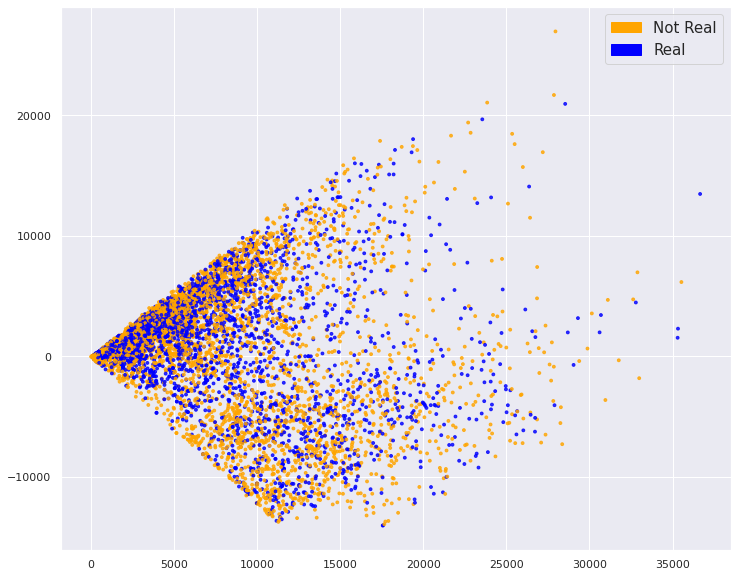

In [ ]:
fig = plt.figure(figsize=(12, 10))          
plot_LSA(trainTWT, train['target'])
plt.show()

In [ ]:
# Recomended 10-20 epochs
history=model.fit(X_train,y_train,batch_size=4,epochs=10,validation_data=(X_test,y_test),verbose=2)

Epoch 1/10
1523/1523 - 82s - loss: 0.5234 - accuracy: 0.7575 - val_loss: 0.4630 - val_accuracy: 0.7853
Epoch 2/10
1523/1523 - 82s - loss: 0.4607 - accuracy: 0.7931 - val_loss: 0.4629 - val_accuracy: 0.7932
Epoch 3/10
1523/1523 - 83s - loss: 0.4532 - accuracy: 0.7992 - val_loss: 0.4319 - val_accuracy: 0.8076
Epoch 4/10
1523/1523 - 82s - loss: 0.4430 - accuracy: 0.8094 - val_loss: 0.4660 - val_accuracy: 0.8043
Epoch 5/10
1523/1523 - 82s - loss: 0.4339 - accuracy: 0.8107 - val_loss: 0.4372 - val_accuracy: 0.8096
Epoch 6/10
1523/1523 - 82s - loss: 0.4246 - accuracy: 0.8131 - val_loss: 0.4378 - val_accuracy: 0.8116
Epoch 7/10
1523/1523 - 81s - loss: 0.4214 - accuracy: 0.8131 - val_loss: 0.4230 - val_accuracy: 0.8194
Epoch 8/10
1523/1523 - 81s - loss: 0.4097 - accuracy: 0.8238 - val_loss: 0.4200 - val_accuracy: 0.8168
Epoch 9/10
1523/1523 - 81s - loss: 0.4064 - accuracy: 0.8246 - val_loss: 0.4378 - val_accuracy: 0.8142
Epoch 10/10
1523/1523 - 82s - loss: 0.3950 - accuracy: 0.8304 - val_loss:

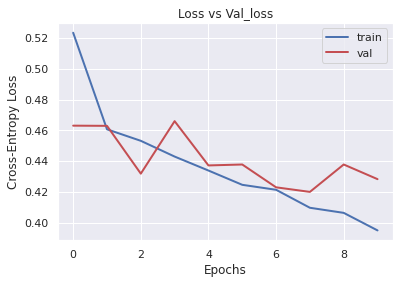

In [ ]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('Loss vs Val_loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

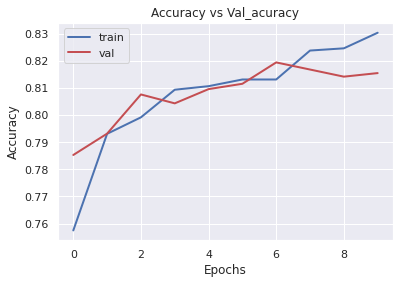

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('Accuracy vs Val_acuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

### Predict using GloVe

In [ ]:
train_pred_GloVe = model.predict(trainTWT)
train_pred_GloVe_int = train_pred_GloVe.round().astype('int')

## Confusion Matrix

In [ ]:
# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "GnBu", annot=annot, fmt='', ax=ax)


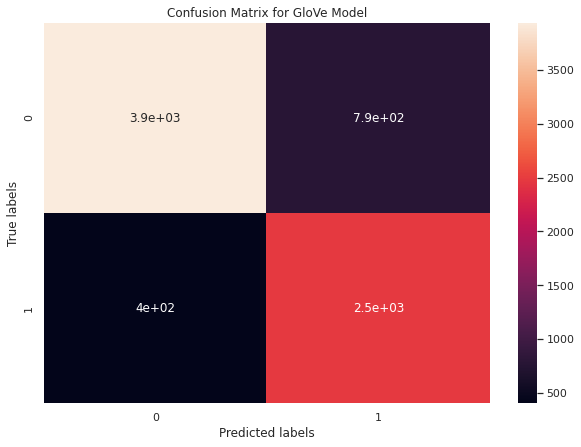

In [ ]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10,7))
cm = confusion_matrix(train_pred_GloVe_int, train['target'].values)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
plt.title("Confusion Matrix for GloVe Model")
plt.show()

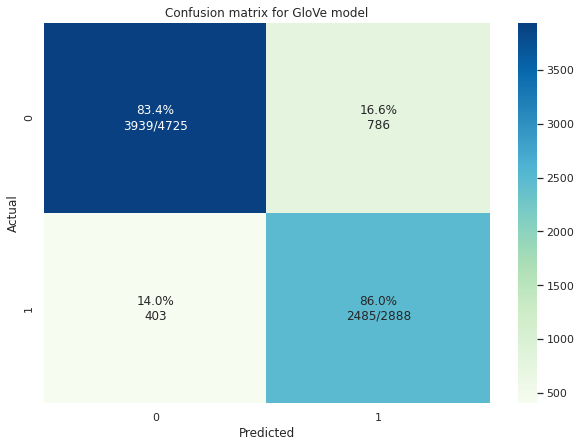

In [ ]:
# Showing Confusion Matrix for GloVe model
from sklearn.metrics import confusion_matrix
plot_cm(train_pred_GloVe_int, train['target'].values, 'Confusion matrix for GloVe model', figsize=(10,7))

##References



1.   https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove/notebook?select=test.csv 
2.   https://www.kaggle.com/vbmokin/nlp-eda-bag-of-words-tf-idf-glove-bert/data#Real-or-Not?-NLP-with-Disaster-Tweets
3. https://towardsdatascience.com/text-classification-on-disaster-tweets-with-lstm-and-word-embedding-df35f039c1db
4. https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert#0.-Introduction-and-References





